# Tutorial on ProfileHistogram

In [1]:
from matplotlib import pyplot as plt
import poisson_approval as pa

## Profile

Generate a random profile:

In [2]:
generator_profile = pa.GeneratorProfileHistogramUniform(n_bins = 10)
profile = generator_profile()
profile

<abc: 0.04477112760394042 [0.02733593 0.0254004  0.08686327 0.29494647 0.1071913  0.00713374
 0.05069472 0.07030596 0.21674723 0.11338099], acb: 0.00637716318074022 [0.06911736 0.25727278 0.01167343 0.1200638  0.33667857 0.0230838
 0.02296106 0.00850083 0.02849692 0.12215145], bac: 0.0728143793890591 [0.11752635 0.03888622 0.07077817 0.17470001 0.08543158 0.02786895
 0.22368162 0.04918734 0.18670932 0.02523044], bca: 0.33472741935751227 [0.01428321 0.00889946 0.22474271 0.06056195 0.11752904 0.04026981
 0.3646511  0.02574448 0.08137808 0.06194016], cab: 0.37135671605211495 [0.07352354 0.12197224 0.14612472 0.01471396 0.09794938 0.11401528
 0.11293961 0.19887983 0.05940027 0.06048118], cba: 0.16995319441663304 [0.05673732 0.01539995 0.02618386 0.28069404 0.00837357 0.08411518
 0.00497543 0.04266208 0.39912737 0.08173121]> (Condorcet winner: c)

Share of each ranking:

In [3]:
profile.d_ranking_share

{abc: 0.04477112760394042, acb: 0.00637716318074022, bac: 0.0728143793890591, bca: 0.33472741935751227, cab: 0.37135671605211495, cba: 0.16995319441663304}

Distribution of the utilities for voters $abc$:

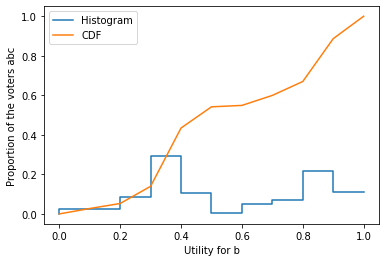

In [4]:
ranking = 'abc'
profile.plot_histogram(ranking, label='Histogram')
profile.plot_cdf(ranking, label='CDF')
plt.ylabel('Proportion of the voters %s' % ranking)
plt.legend()

## Strategic Analysis

Generate a random strategy:

In [5]:
generator_strategy = pa.GeneratorStrategyThresholdUniform()
strategy = generator_strategy()
strategy

<abc: utility-dependent (0.007283026175163965), acb: utility-dependent (0.41195951430171107), bac: utility-dependent (0.5755262413553989), bca: utility-dependent (0.15329931141455655), cab: utility-dependent (0.17148163760390278), cba: utility-dependent (0.4068462977459244)>

Tau vector (ballot shares) associated to the strategy in the given profile:

In [6]:
tau = profile.tau(strategy)
tau

<a: 0.0032674643704393618, ab: 0.08047967603668002, ac: 0.3148743285787048, b: 0.04338540853215641, bc: 0.4337996325628845, c: 0.12419348991913495> ==> c

Is the strategy an equilibrium for the given profile?

In [7]:
profile.is_equilibrium(strategy)

EquilibriumStatus.NOT_EQUILIBRIUM

Use iterated voting to search for an equilibrium:

In [8]:
result = profile.iterated_voting(init=strategy, n_max_episodes=1000, 
                                 ballot_update_ratio=0.1)
cycle_taus_actual = result['cycle_taus_actual']
cycle_strategies = result['cycle_strategies']

In [9]:
cycle_taus_actual

[<ab: 0.09217265795211504, ac: 0.15399658416869957, b: 0.3601402683983966, c: 0.3936904894807888> ==> c]

In [10]:
if len(cycle_taus_actual) == 0:
    print('No convergence.')
elif len(cycle_taus_actual) == 1:
    print('Convergence to an equilibrium.')
    print('Limit strategy: %s' % cycle_strategies[0])
    print('Limit tau-vector: %s' % cycle_taus_actual[0])
else:
    print('Convergence to a cycle of cardinality %s.' % len(cycle_taus_actual))

Convergence to an equilibrium.
Limit strategy: <abc: ab, acb: ac, bac: utility-dependent (0.3697297732368909), bca: b, cab: utility-dependent (0.630270226763109), cba: c> ==> c
Limit tau-vector: <ab: 0.09217265795211504, ac: 0.15399658416869957, b: 0.3601402683983966, c: 0.3936904894807888> ==> c


There is another version of iterated voting, ``fictitious_play``. It allows for update ratios that depend on time, it is faster, but it is not able to detect limit cycles (only convergence). Cf. Reference section for more information.

In [11]:
from math import log
result = profile.fictitious_play(init=strategy, n_max_episodes=1000, 
                                 perception_update_ratio=pa.one_over_log_t_plus_two,
                                 ballot_update_ratio=0.1)
limit_tau = result['tau']
limit_strategy = result['strategy']

In [12]:
if limit_tau is None:
    print('No convergence.')
else:
    print('Convergence to an equilibrium.')
    print('Limit strategy: %s' % limit_strategy)
    print('Limit tau-vector: %s' % limit_tau)

Convergence to an equilibrium.
Limit strategy: <abc: ab, acb: ac, bac: utility-dependent (0.3697297741192059), bca: b, cab: utility-dependent (0.6302702258807941), cba: c> ==> c
Limit tau-vector: <ab: 0.09217265783987855, ac: 0.1539965845387502, b: 0.36014026851063324, c: 0.393690489110738> ==> c


The methods ``iterated_voting`` and ``fictitious_play`` also provide the winning frequency of each candidate. In case of convergence to a limit or a periodical orbit, these frequencies are computed at the limit. In case of non-convergence, it gives the winning frequencies on the history of the process.

In [13]:
result = profile.iterated_voting(init=strategy, n_max_episodes=10, 
                                 ballot_update_ratio=0.1)
result['d_candidate_winning_frequency']

{c: 1}

If you want to convert these winning frequencies to an array, you can use the function ``d_candidate_value_to_array``:

In [14]:
pa.d_candidate_value_to_array(result['d_candidate_winning_frequency'])

array([Fraction(0, 1), Fraction(0, 1), Fraction(1, 1)], dtype=object)